#### load python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.plot import styles
import os
import shutil
import pandas as pd
import pyemu

C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


#### specify folder location of modflow 6 model files

In [3]:
tpl_dir = os.path.join("data", "mumodel_tpl")

#### instantiate a flopy model object from the files copied to the new folder

In [4]:
name = "mumodel"
exe_name = "mf6"
sim = flopy.mf6.MFSimulation.load(sim_ws=tpl_dir)
m = sim.get_model(name)
mg = m.modelgrid

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package chd...
    loading package obs...
  loading solution package mumodel...


#### force flopy to create external pointer files for stress period data and property arrays (much easier for PEST/pyemu to deal with)

In [5]:
m.set_all_data_external()
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mumodel...
  writing model mumodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package wel-1...
    writing package rch-1...
    writing package chd-from-ibound...
    writing package obs_0...


#### run the model again just to make sure it still works

In [6]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\..\..\A\envs\pyclass\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither

(True, [])

#### specify a new folder location for pyemu to work on a copy of the model files

In [7]:
pst_dir = os.path.join("data", "mumodel_pst")

## The pyemu PstFrom method sets up an object to hold all of your PEST related data like observations to track and parameters to modify, making it super easy to change and write new PEST input files on the fly.

In [8]:
pf = pyemu.utils.PstFrom(original_d=tpl_dir, new_d=pst_dir, remove_existing=True, spatial_reference=mg)

2024-03-30 15:47:26.193648 starting: opening PstFrom.log for logging
2024-03-30 15:47:26.193648 starting PstFrom process
2024-03-30 15:47:26.193648 starting: setting up dirs
2024-03-30 15:47:26.200958 starting: removing existing new_d 'data\mumodel_pst'
2024-03-30 15:47:26.239464 finished: removing existing new_d 'data\mumodel_pst' took: 0:00:00.038506
2024-03-30 15:47:26.239464 starting: copying original_d 'data\mumodel_tpl' to new_d 'data\mumodel_pst'
2024-03-30 15:47:26.335157 finished: copying original_d 'data\mumodel_tpl' to new_d 'data\mumodel_pst' took: 0:00:00.095693
2024-03-30 15:47:26.335157 finished: setting up dirs took: 0:00:00.141509


#### python package OS has a lot of useful functions for navigating your data directories. here are all the files and subfolders right now in the new pst_dir folder

In [9]:
os.listdir(pst_dir)

['hds.csv',
 'mfsim.lst',
 'mfsim.nam',
 'mult',
 'mumodel.dis',
 'mumodel.dis.grb',
 'mumodel.dis_botm.txt',
 'mumodel.dis_delc.txt',
 'mumodel.dis_delr.txt',
 'mumodel.dis_top.txt',
 'mumodel.ib.chd.obs',
 'mumodel.ib.ibound.chd',
 'mumodel.ib.ibound.chd_stress_period_data_1.txt',
 'mumodel.ic',
 'mumodel.ic_strt.txt',
 'mumodel.ims',
 'mumodel.lst',
 'mumodel.nam',
 'mumodel.npf',
 'mumodel.npf_icelltype.txt',
 'mumodel.npf_k.txt',
 'mumodel.obs',
 'mumodel.obs_continuous_hds.csv.txt',
 'mumodel.oc',
 'mumodel.rch',
 'mumodel.rch_recharge_1.txt',
 'mumodel.rch_recharge_13.txt',
 'mumodel.rch_recharge_14.txt',
 'mumodel.rch_recharge_15.txt',
 'mumodel.rch_recharge_16.txt',
 'mumodel.rch_recharge_17.txt',
 'mumodel.rch_recharge_18.txt',
 'mumodel.rch_recharge_19.txt',
 'mumodel.rch_recharge_2.txt',
 'mumodel.rch_recharge_20.txt',
 'mumodel.rch_recharge_25.txt',
 'mumodel.rch_recharge_3.txt',
 'mumodel.rch_recharge_4.txt',
 'mumodel.rch_recharge_5.txt',
 'mumodel.rch_recharge_6.txt',
 

## we will be using globally-constant parameters, pilot-point interpolated parameters, and individual grid scale parameters to impart our ignorance of model properties at 3 difference spatial scales

#### to implement pilot point interpolated parameters and gridscale parameters we need to specify a geostatistical variogram for each

In [10]:
vr_pp = pyemu.utils.geostats.ExpVario(a=2000, contribution=1.0)
vr_gr = pyemu.utils.geostats.ExpVario(a=500, contribution=1.0)

In [11]:
gs_pp = pyemu.utils.geostats.GeoStruct(variograms=vr_pp, transform="log")
gs_gr = pyemu.utils.geostats.GeoStruct(variograms=vr_gr, transform="log")

## for array-type properties K and SY, we will perform the same operations for each, so we'll run it in a loop and use a dictionary to specify the names and values that are specific to each property

In [12]:
# {"property_name": (lower bound value, upper bound value)}
property_dict = {"npf_k": (10., 200.), "sto_sy": (0.05, 0.35)}

for prop, (lb, ub) in property_dict.items():
    filenames=['mumodel.{0}.txt'.format(prop)]
    pf.add_parameters(filenames, par_type="constant", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_cn", ult_ubound=ub, ult_lbound=lb)
    pf.add_parameters(filenames, par_type="pilotpoint", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_pp", pp_space=4, ult_ubound=ub, ult_lbound=lb, geostruct=gs_pp)
    pf.add_parameters(filenames, par_type="grid", upper_bound=2., lower_bound=0.5,
                      par_name_base=prop, pargp=prop.split("_")[0] + "_gr", ult_ubound=ub, ult_lbound=lb, geostruct=gs_gr)

2024-03-30 15:54:14.759054 transform was not passed, setting default tranform to 'log'
2024-03-30 15:54:14.805699 starting: adding constant type m style parameters for file(s) ['mumodel.npf_k.txt']
2024-03-30 15:54:14.805699 starting: loading array data\mumodel_pst\mumodel.npf_k.txt
2024-03-30 15:54:14.805699 finished: loading array data\mumodel_pst\mumodel.npf_k.txt took: 0:00:00
2024-03-30 15:54:14.805699 loaded array 'data\mumodel_tpl\mumodel.npf_k.txt' of shape (21, 9)
2024-03-30 15:54:14.805699 starting: writing array-style template file 'data\mumodel_pst\npf_k_inst0_constant.csv.tpl'
2024-03-30 15:54:14.805699 starting: writing template file data\mumodel_pst\npf_k_inst0_constant.csv.tpl for ['npf_k_inst:0']
2024-03-30 15:54:14.818713 finished: writing template file data\mumodel_pst\npf_k_inst0_constant.csv.tpl for ['npf_k_inst:0'] took: 0:00:00.013014
2024-03-30 15:54:14.818713 starting: writing array-based template file 'data\mumodel_pst\npf_k_inst0_constant.csv.tpl'
2024-03-30 

#### for recharge we will use time-constant multipliers on the global and pilot point spatial scales

In [13]:
filenames=[x for x in os.listdir(pst_dir) if x.startswith("mumodel.rch_recharge_")]

pf.add_parameters(filenames, par_type="constant", upper_bound=1.25, lower_bound=0.75,
                  par_name_base='rch_r', pargp="rch_cn")
pf.add_parameters(filenames, par_type="pilotpoint", upper_bound=1.25, lower_bound=0.75,
                  par_name_base='rch_r', pargp="rch_pp", pp_space=4, geostruct=gs_pp)

2024-03-30 15:55:28.094122 transform was not passed, setting default tranform to 'log'
2024-03-30 15:55:28.096193 starting: adding constant type m style parameters for file(s) ['mumodel.rch_recharge_1.txt', 'mumodel.rch_recharge_13.txt', 'mumodel.rch_recharge_14.txt', 'mumodel.rch_recharge_15.txt', 'mumodel.rch_recharge_16.txt', 'mumodel.rch_recharge_17.txt', 'mumodel.rch_recharge_18.txt', 'mumodel.rch_recharge_19.txt', 'mumodel.rch_recharge_2.txt', 'mumodel.rch_recharge_20.txt', 'mumodel.rch_recharge_25.txt', 'mumodel.rch_recharge_3.txt', 'mumodel.rch_recharge_4.txt', 'mumodel.rch_recharge_5.txt', 'mumodel.rch_recharge_6.txt', 'mumodel.rch_recharge_7.txt', 'mumodel.rch_recharge_8.txt']
2024-03-30 15:55:28.096193 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)
2024-03-30 15:55:28.096193 starting: loading array data\mumodel_pst\mumodel.rch_recharge_1.txt
2024-03-30 15:55:28.102517 finished: loading array data\mumodel_ps

C:\A\envs\pyclass\Lib\site-packages\pyemu\logger.py:100: PyemuWarning: 2024-03-30 15:55:28.096193 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)

C:\A\envs\pyclass\Lib\site-packages\pyemu\logger.py:100: PyemuWarning: 2024-03-30 15:55:28.215666 WARNING: Discrepancy between number of filenames (17) and number of formatter strings (1). Will repeat first (free)



2024-03-30 15:55:28.310524 starting: writing array-based template file 'data\mumodel_pst\rch_r_inst1pp.dat.tpl'
2024-03-30 15:55:28.310524 saving zone array data\mumodel_pst\rch_r_inst1pp.dat.zone for tpl file data\mumodel_pst\rch_r_inst1pp.dat.tpl
2024-03-30 15:55:28.316348 finished: adding pilotpoint type m style parameters for file(s) ['mumodel.rch_recharge_1.txt', 'mumodel.rch_recharge_13.txt', 'mumodel.rch_recharge_14.txt', 'mumodel.rch_recharge_15.txt', 'mumodel.rch_recharge_16.txt', 'mumodel.rch_recharge_17.txt', 'mumodel.rch_recharge_18.txt', 'mumodel.rch_recharge_19.txt', 'mumodel.rch_recharge_2.txt', 'mumodel.rch_recharge_20.txt', 'mumodel.rch_recharge_25.txt', 'mumodel.rch_recharge_3.txt', 'mumodel.rch_recharge_4.txt', 'mumodel.rch_recharge_5.txt', 'mumodel.rch_recharge_6.txt', 'mumodel.rch_recharge_7.txt', 'mumodel.rch_recharge_8.txt'] took: 0:00:00.100682


,name,x,y,zone,parval1,k,i,j,parnme,tpl,...,pp_filename,pargp,dercom,offset,parchglim,parlbnd,partrans,parubnd,scale,partype
parnme,,,,,,,,,,,,,,,,,,,,,
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,pp_0000,1250.0,9250.0,1,1.0,0,2,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,pp_0001,3250.0,9250.0,1,1.0,0,2,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:2_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,pp_0002,1250.0,7250.0,1,1.0,0,6,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,pp_0003,3250.0,7250.0,1,1.0,0,6,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:6_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,pp_0004,1250.0,5250.0,1,1.0,0,10,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,pp_0005,3250.0,5250.0,1,1.0,0,10,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:10_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,pp_0006,1250.0,3250.0,1,1.0,0,14,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,pp_0007,3250.0,3250.0,1,1.0,0,14,6,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:14_j:6_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint
pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,pp_0008,1250.0,1250.0,1,1.0,0,18,2,pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1,~ pname:rch_r_inst:1_ptype:pp_pstyle:m_i:18_j:2_zone:1 ~,...,data\mumodel_pst\rch_r_inst1pp.dat,rch_pp,1,0.0,factor,0.75,log,1.25,1.0,pilotpoint


## add observations to track

#### the "hds.csv" output file was created in a previous notebook when instantiating the OBS package. The output file format has simulation time in the first column, then simulated head timeseries values for 2 locations in the next 2 columns

In [14]:
hds_df = pf.add_observations(filename="hds.csv", index_cols=0, use_cols=[1, 2], obsgp="hds")

2024-03-30 15:56:52.071362 starting: adding observations from output file hds.csv
2024-03-30 15:56:52.071362 starting: adding observations from tabular output file '['hds.csv']'
2024-03-30 15:56:52.071362 starting: reading list-style file: data\mumodel_pst\hds.csv
2024-03-30 15:56:52.092683 finished: reading list-style file: data\mumodel_pst\hds.csv took: 0:00:00.021321
2024-03-30 15:56:52.098009 starting: building insfile for tabular output file hds.csv
2024-03-30 15:56:52.107536 finished: building insfile for tabular output file hds.csv took: 0:00:00.009527
2024-03-30 15:56:52.107536 starting: adding observation from instruction file 'data\mumodel_pst\hds.csv.ins'
2024-03-30 15:56:52.118177 finished: adding observation from instruction file 'data\mumodel_pst\hds.csv.ins' took: 0:00:00.010641
2024-03-30 15:56:52.133816 finished: adding observations from tabular output file '['hds.csv']' took: 0:00:00.062454
2024-03-30 15:56:52.133816 finished: adding observations from output file hds.

C:\A\envs\pyclass\Lib\site-packages\pyemu\utils\pst_from.py:1484: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
C:\A\envs\pyclass\Lib\site-packages\pyemu\utils\pst_from.py:1502: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


#### the PstFrom method add_observations() creates a pandas dataframe that we can clean up to name the observations and groups according to our preferred conventions

In [15]:
hds_df.loc[:, "time"] = hds_df.loc[:, "obsnme"].apply(lambda x: float(x.split(":")[-1]))

In [16]:
hds_df.loc[:, "datetime"] = hds_df.loc[:, "time"].apply(lambda x: pd.to_datetime("20200101") + np.timedelta64(int(x), "D"))

In [17]:
hds_df.loc[:, "obgnme"] = hds_df.loc[:, "obsnme"].apply(lambda x: x.split("usecol:")[-1].split("_time")[0])

#### lets pretend the first year of the model is a historical period where we want to match simulated outputs to observed measurements, and everything after that is a forecast period. We assign an observation weight of zero to all simulated values in the forecast period

In [18]:
hds_df.loc[hds_df["datetime"].apply(lambda x: x.year>2020), "weight"] = 0.

In [19]:
hds_df.loc[:, "datetime1"] = hds_df.loc[:, "datetime"].apply(lambda x: x.strftime("%Y%m%d"))

In [20]:
hds_df.drop(["time", "datetime"], axis=1, inplace=True)

In [21]:
hds_df.rename(columns={"datetime1":"datetime"}, inplace=True)

In [22]:
hds_df.sort_values("obsnme", inplace=True)

## PYEMU will write a python script that runs the model after every parameter adjustment. We need to tell it how to run our modflow model. MODFLOW 6 is super simple in this regard, just call the .exe file name within the model folder and it will find the model name file

In [23]:
pf.mod_sys_cmds.append("mf6")

## BUILD THE DANG PEST INPUT FILES

In [24]:
pst = pf.build_pst(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:0, npar_adj:411, nnz_obs:192
2024-03-30 16:02:15.891264 forward_run line:pyemu.os_utils.run(r'mf6')



C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:1362: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\A\envs\pyclass\Lib\site-packages\pyemu\pst\pst_handler.py:3866: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf' 'npf'
 'npf' 'npf' 'np

#### since we modified the observation data frame created by pyemu, I think we have to assign it to the observation_data attribute of the pest object that pyemu created 

In [25]:
pst.observation_data = hds_df

#### define noptmax = 0 to just run the model a single time

In [26]:
# write pst control file
pst.control_data.noptmax = 0
pst.pestpp_options["additional_ins_delimiters"] = ","
pst.write(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:0, npar_adj:411, nnz_obs:192


#### pick a size for our parameter ensemble (bigger=better, until you run out of cores and/or time)

In [27]:
ies_num_reals=200

#### draw the realizations for the prior parameter ensemble. Each model realization gets assigned parameter values pulled randomly from a multivariate distribution

In [28]:
# draw prior
print("drawing {0} realization from prior parameter distribution".format(ies_num_reals))
pe = pf.draw(ies_num_reals, use_specsim=True)
pe.to_binary(os.path.join(pst_dir, "prior.jcb"))

drawing 200 realization from prior parameter distribution
2024-03-30 16:06:12.378055 starting: drawing realizations
2024-03-30 16:06:12.384160 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-30 16:06:12.429583 starting: SpecSim: drawing 200 realization for group npf_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406)
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-30 16:06:12.488996 finished: SpecSim: drawing 200 realization for group npf_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406) took: 0:00:00.059413
2024-03-30 16:06:12.488996 starting: SpecSim: drawing 200 realization for group sto_gr with 189 pars, (log) variance 0.01006878425438406 (sill 0.01006878425438406)
SpecSim.initialize() summary: full_delx X full_dely: 37 X 37
2024-03-30 16:06:12.540261 finished: SpecSim: drawing 200 realization for group sto_gr with 189 pars, (log) var

In [29]:
pst.pestpp_options["ies_par_en"] = "prior.jcb"
pst.pestpp_options["ies_num_reals"] = ies_num_reals

#### copy the pest executable into our template directory

In [30]:
shutil.copy2(os.path.join("bin", "pestpp-ies.exe"), os.path.join(pst_dir, "pestpp-ies.exe"))

'data\\mumodel_pst\\pestpp-ies.exe'

#### run the model through pest a single time to make sure the plumbing is connected

In [31]:
pyemu.os_utils.run("pestpp-ies mumodel.pst", cwd=pst_dir)

## increase noptmax (or set to -1 to just run a sweep of the model realizations drawn from our prior parameter distribution)

In [32]:
# write pst control file
pst.control_data.noptmax = 2
pst.write(os.path.join(pst_dir, "mumodel.pst"), version=2)

noptmax:2, npar_adj:411, nnz_obs:192


In [37]:
master_dir = os.path.join("data", "master_pst")

#### select number of workers to run in parallel (rule of thumb, try half the number of total logical processors in task manager)

In [38]:
num_workers=8

In [33]:
pyemu.os_utils.start_workers(pst_dir, "pestpp-ies.exe", "mumodel.pst", num_workers=num_workers, worker_root=".", master_dir=master_dir)

## let's investigate the ensemble output

#### load the observation_data object to find and relate certain obs from our output

In [34]:
obs = pst.observation_data

In [35]:
obs.loc[:, "datetime"] = pd.to_datetime(obs.loc[:, "datetime"])

In [36]:
obs.sort_values(["obgnme", "datetime"], inplace=True)

#### load the ensemble results. for the prior and for each upgrade iteration, there is a dataframe of N REALIZATION rows and N OBSERVATIONS columns

In [39]:
oe = {}
for n in [0, 1, 2]:
    oe[n] = pd.read_csv(os.path.join(master_dir, "mumodel.{0}.obs.csv".format(n)), index_col=0)

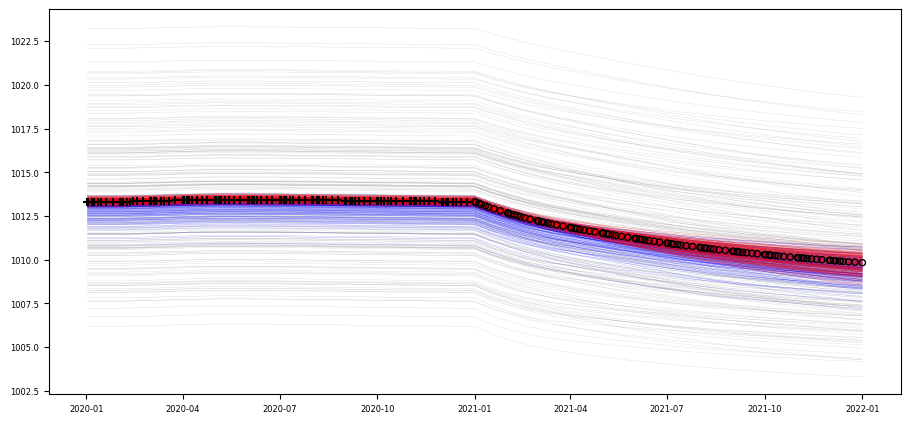

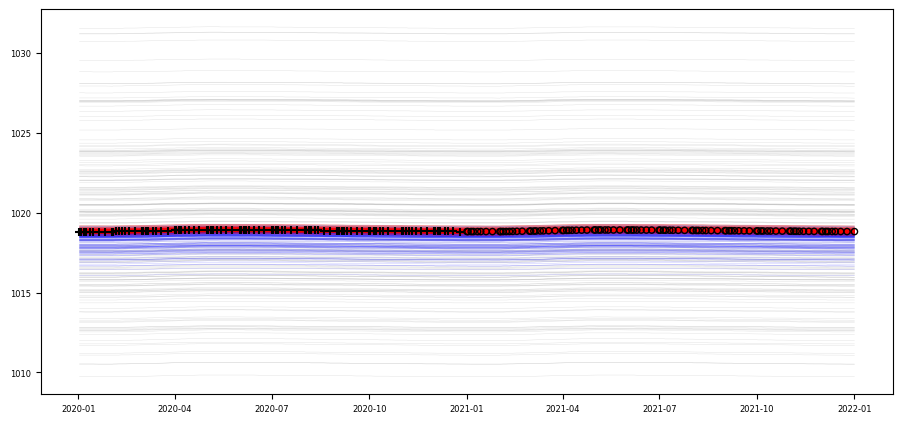

In [42]:
for i, g in pst.observation_data.groupby("obgnme"):
    f, ax = plt.subplots(1,1,figsize=(11,5), dpi=100)
    
    for n, clr in zip([0, 1, 2], ["0.5", "b", "r"]):
        for ii, rr in oe[n].iterrows():
            ax.plot(g.datetime, oe[n].loc[ii, g.obsnme], lw=0.25, c=clr, alpha=0.3)

    nz = g.loc[g["weight"]>0.]
    ax.scatter(nz["datetime"], nz["obsval"], marker="+", c="k", s=40, zorder=10)
    
    zw = g.loc[g["weight"]==0.]
    ax.scatter(zw["datetime"], zw["obsval"], marker="o", facecolor="None", edgecolor="k", s=20, zorder=10)

#### lets look at how parameter distributions changed from prior to posterior

In [45]:
pe = {}
for n in [0, 1, 2]:
    pe[n] = pd.read_csv(os.path.join(master_dir, "mumodel.{0}.par.csv".format(n)), index_col=0)

In [46]:
par = pst.parameter_data

In [47]:
par.pargp.unique()

array(['npf_cn', 'npf_pp', 'npf_gr', 'sto_cn', 'sto_pp', 'sto_gr',
       'rch_cn', 'rch_pp'], dtype=object)

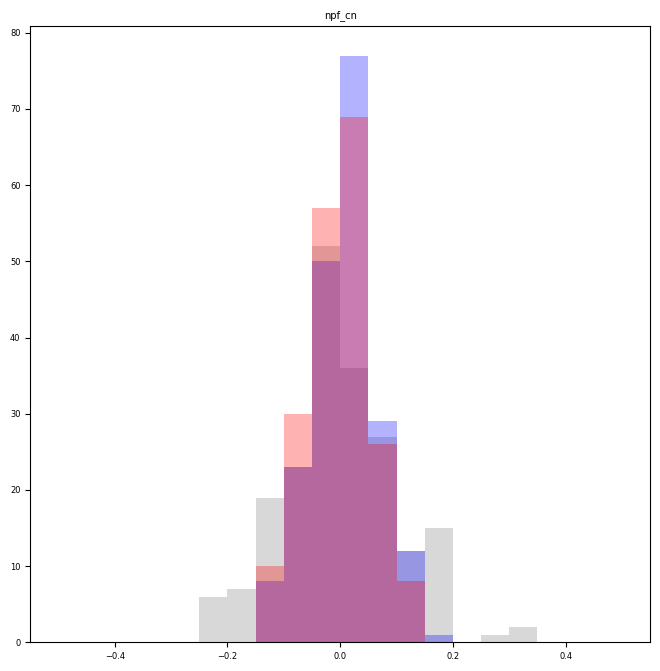

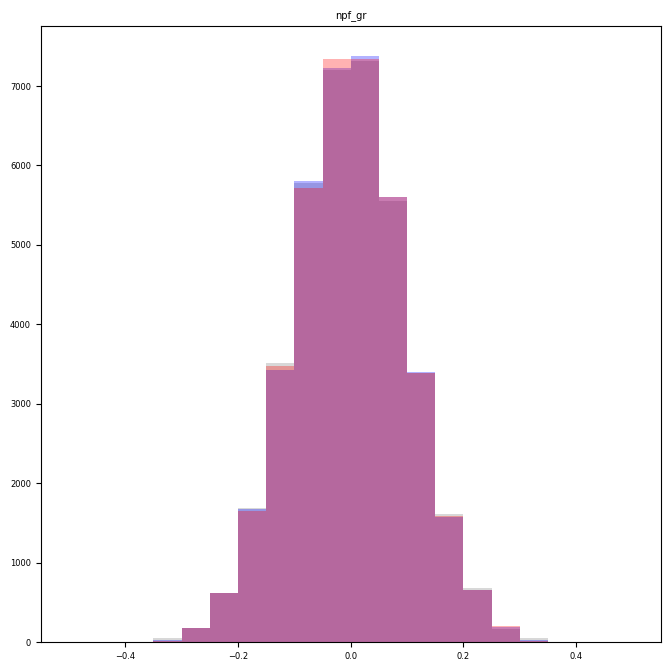

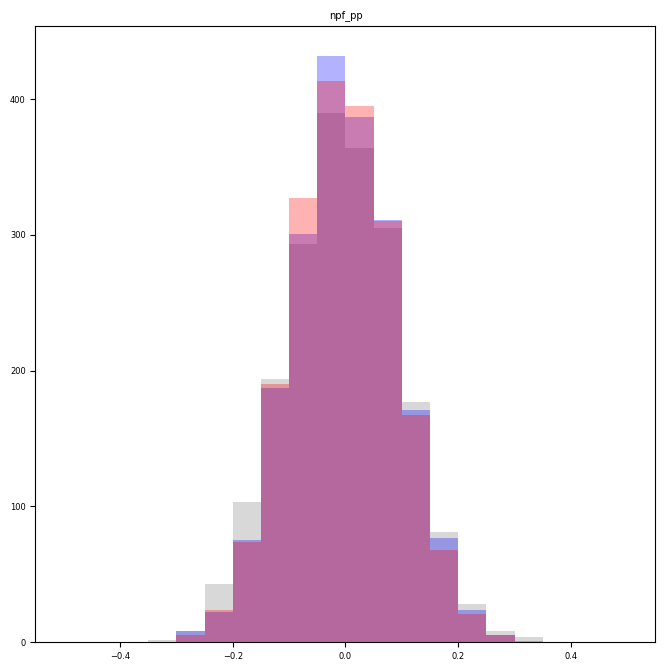

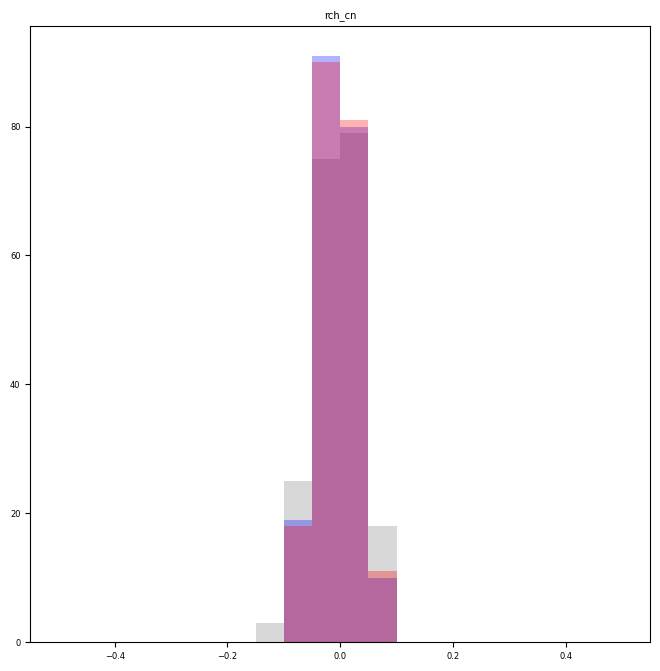

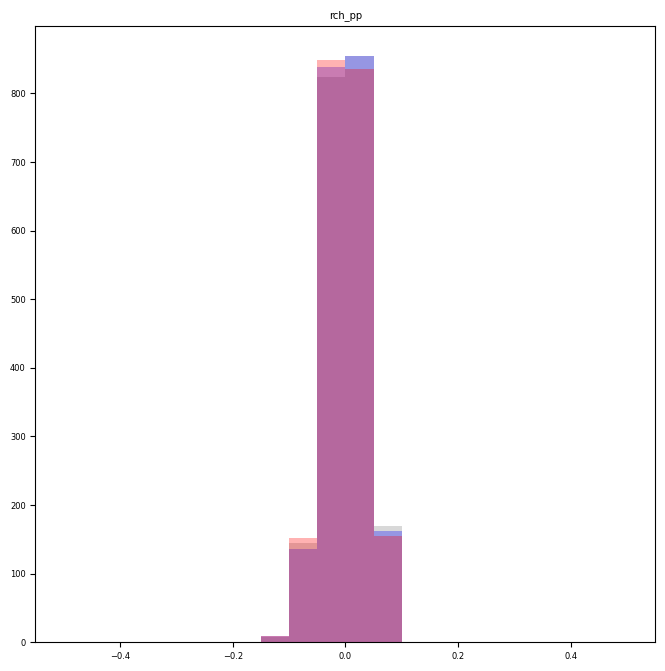

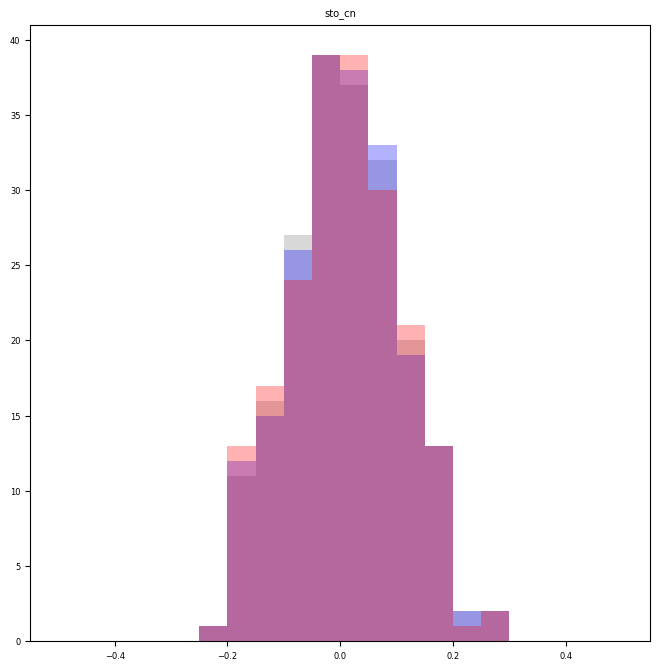

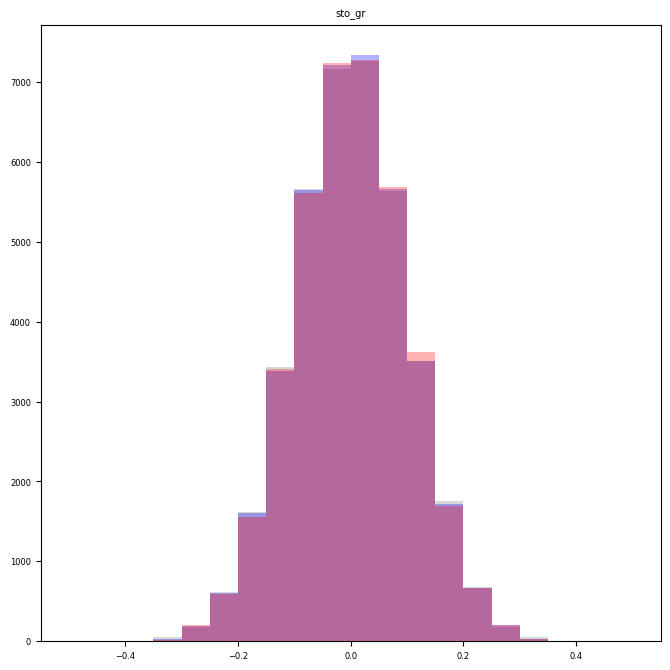

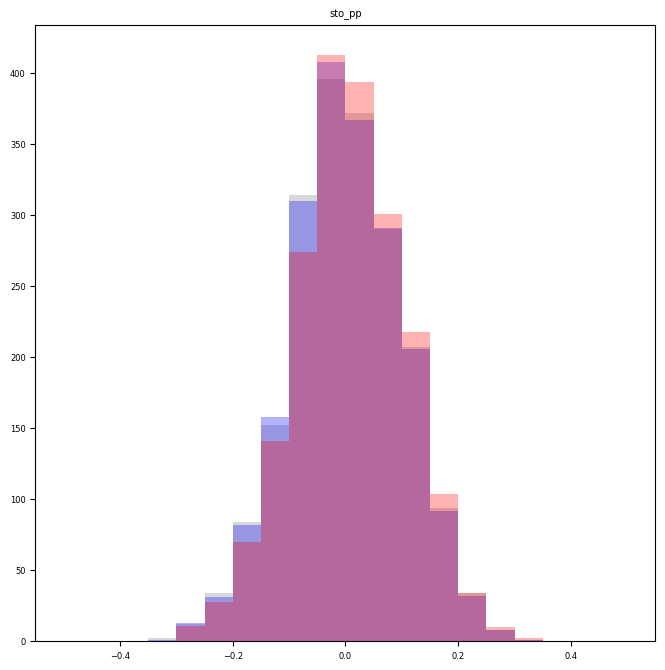

In [48]:
#for ix in par.loc[par["ptype"]=="cn"].index:
for i, g in par.groupby("pargp"):
    ix = g.parnme.values
    f, ax = plt.subplots(1,1,figsize=(8,8), dpi=100)

    for n, clr in zip([0, 1, 2], ["0.5", "b", "r"]):
        data = np.log10(pe[n].loc[:, ix].values.ravel())
        ax.hist(data, lw=0.25, facecolor=clr, alpha=0.3, bins=np.linspace(-0.5, 0.5, 21))
    ax.set_title(i)

#### PYEMU has built in plotting functions do to the above and much more

In [59]:
pe_pr = pyemu.ParameterEnsemble.from_csv(pst=pst, filename=os.path.join(master_dir, "mumodel.0.par.csv"))

In [61]:
log_pe_pr.values = np.log10(pe_pr.values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [52]:
pe_pt1 = pyemu.ParameterEnsemble.from_csv(pst=pst, filename=os.path.join(master_dir, "mumodel.1.par.csv"))
log_pe_pt1 = np.log10(pe_pt1)

In [53]:
pe_pt2 = pyemu.ParameterEnsemble.from_csv(pst=pst, filename=os.path.join(master_dir, "mumodel.2.par.csv"))
log_pe_pt2 = np.log10(pe_pt2)

In [56]:
log_pe_pr

array([[-0.12133232, -0.13460936, -0.04632921, ..., -0.00711658,
        -0.01243249, -0.00443983],
       [-0.01562888, -0.00323404, -0.05039534, ..., -0.03133963,
        -0.03121362, -0.00669694],
       [ 0.00128794, -0.0454912 ,  0.10147899, ...,  0.03877907,
        -0.03973762, -0.002197  ],
       ...,
       [-0.09459813, -0.03246326, -0.07309498, ..., -0.01460002,
        -0.01261576,  0.01638977],
       [ 0.00253754,  0.12842512,  0.05848296, ..., -0.0209586 ,
         0.03599775,  0.0029734 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [54]:
pdict = par.groupby("pargp").groups

In [55]:
print("plotting {0} pargp histograms".format(len(pdict.keys())))
pyemu.plot_utils.ensemble_helper({"0.5": log_pe_pr, "b": log_pe_pt1, "r": log_pe_pt2},
                                 plot_cols=pdict, filename=os.path.join(master_dir, "mumodel_par_hist_log.pdf"))

plotting 8 pargp histograms
2024-03-30 16:31:29.565831 ERROR: unrecognized ensemble list arg:[[-0.12133232 -0.13460936 -0.04632921 ... -0.00711658 -0.01243249
  -0.00443983]
 [-0.01562888 -0.00323404 -0.05039534 ... -0.03133963 -0.03121362
  -0.00669694]
 [ 0.00128794 -0.0454912   0.10147899 ...  0.03877907 -0.03973762
  -0.002197  ]
 ...
 [-0.09459813 -0.03246326 -0.07309498 ... -0.01460002 -0.01261576
   0.01638977]
 [ 0.00253754  0.12842512  0.05848296 ... -0.0209586   0.03599775
   0.0029734 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Exception: unrecognized ensemble list arg:[[-0.12133232 -0.13460936 -0.04632921 ... -0.00711658 -0.01243249
  -0.00443983]
 [-0.01562888 -0.00323404 -0.05039534 ... -0.03133963 -0.03121362
  -0.00669694]
 [ 0.00128794 -0.0454912   0.10147899 ...  0.03877907 -0.03973762
  -0.002197  ]
 ...
 [-0.09459813 -0.03246326 -0.07309498 ... -0.01460002 -0.01261576
   0.01638977]
 [ 0.00253754  0.12842512  0.05848296 ... -0.0209586   0.03599775
   0.0029734 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

In [ ]:
print("plotting par change summaries from {0}".format(m_d))
pyemu.plot_utils.ensemble_change_summary(pe_pr, pe_pt,
    filename=os.path.join(o_d, "{0}_{1}_par_change.pdf".format(m_d, noptmax)), pst=pst)